In [309]:
import os
import timeit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
from datetime import datetime
from datetime import datetime
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

In [297]:
# Function to plot loss and accuracy
def get_plot_loss_acc(history, model_name):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title(f"{model_name} \n\n Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="lower right")

    plt.tight_layout()


# Function to compute confusion matrix
def compute_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true=y_true.labels, y_pred=np.argmax(y_pred, axis=1))

    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

# Function to evaluate model on data
def get_evaluate(data, name, model):
    score_model = model.evaluate(data, verbose=1)
    print(f"{name} Loss: {score_model[0]:.2f}")
    print(f"{name} Accuracy: {score_model[1]:.2f}")

# Function to make predictions using the model
def get_predict(data, model):
    predict_model = model.predict(data)
    return predict_model

# Function to compute evaluation metrics
def get_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_true, y_pred))


In [3]:
# Define paths and parameters
base_dir = "/Users/seelamakhil/MY MAJORPROJECT/deeee"
train_path = os.path.join(base_dir, '/Users/seelamakhil/Downloads/deeee/train')
valid_path = os.path.join(base_dir, '/Users/seelamakhil/Downloads/deeee/val')
model_name = "Xception"
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

target_size = (224, 224)
epochs = 20  # Increase the number of epochs to 20
batch_size = 32  # Reduce batch size to improve model performance
img_shape = (224, 224, 3)

# Save model path
save_dir = os.path.join(base_dir, 'models')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)  
# Create directory if it doesn't exist
save_model_ft = os.path.join(save_dir, f'model_{model_name}_ft.keras')

In [4]:
# Data generators with and without augmentation
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

# Flow from directory for training and validation
train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True, batch_size=batch_size
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
    batch_size=batch_size
)

# Class labels and weights
y_train = train_generator.labels
y_val = valid_generator.labels
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))


Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [5]:
# Xception model with fine-tuning
model = tf.keras.applications.Xception(
    input_shape=img_shape,
    include_top=False,
    weights="imagenet",
)
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential([
    model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),  # Increase dropout to reduce overfitting
    tf.keras.layers.Dense(5, activation="softmax"),
])

model_ft.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),  # Decrease learning rate for finer updates
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [6]:
# Callbacks for early stopping and learning rate reduction
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.01, patience=8, restore_best_weights=True
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=4, mode='auto'
)

In [7]:
# Model training
start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[plateau],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()
execution_time_ft = (stop_ft - start_ft) / 60
print(f"Model {model_name} fine-tuning executed in {execution_time_ft:.2f} minutes")

# Save the model
model_ft.save(save_model_ft)


Epoch 1/20
181/181 [==============================] - 1316s 7s/step - loss: 1.3003 - accuracy: 0.3607 - val_loss: 1.1940 - val_accuracy: 0.4758 - lr: 1.0000e-04
Epoch 2/20
181/181 [==============================] - 1618s 9s/step - loss: 0.9035 - accuracy: 0.5350 - val_loss: 1.7725 - val_accuracy: 0.3378 - lr: 1.0000e-04
Epoch 3/20
181/181 [==============================] - 1878s 10s/step - loss: 0.7946 - accuracy: 0.5786 - val_loss: 1.2509 - val_accuracy: 0.4383 - lr: 1.0000e-04
Epoch 4/20
181/181 [==============================] - 2165s 12s/step - loss: 0.7456 - accuracy: 0.6083 - val_loss: 1.2790 - val_accuracy: 0.4939 - lr: 1.0000e-04
Epoch 5/20
181/181 [==============================] - 2216s 12s/step - loss: 0.7050 - accuracy: 0.6158 - val_loss: 1.1266 - val_accuracy: 0.4879 - lr: 1.0000e-04
Epoch 6/20
181/181 [==============================] - 2272s 13s/step - loss: 0.6511 - accuracy: 0.6450 - val_loss: 1.1421 - val_accuracy: 0.5351 - lr: 1.0000e-04
Epoch 7/20
181/181 [==========

26/26 [==============================] - 29s 1s/step - loss: 1.2464 - accuracy: 0.5533
Validation Loss: 1.25
Validation Accuracy: 0.55
26/26 [==============================] - 32s 1s/step
Accuracy Score - Xception: 0.55
Balanced Accuracy Score - Xception: 0.62


              precision    recall  f1-score   support

           0       0.71      0.52      0.60       328
           1       0.30      0.46      0.36       153
           2       0.59      0.56      0.58       212
           3       0.61      0.72      0.66       106
           4       0.74      0.85      0.79        27

    accuracy                           0.55       826
   macro avg       0.59      0.62      0.60       826
weighted avg       0.59      0.55      0.56       826



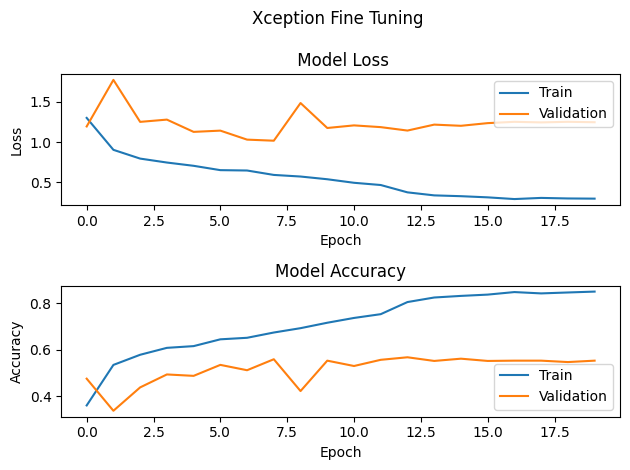

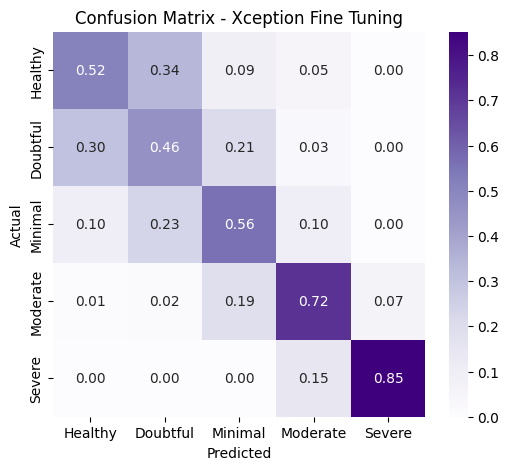

In [298]:
# Plot loss and accuracy
get_plot_loss_acc(history, f"{model_name} Fine Tuning")

# Evaluate on validation data
get_evaluate(valid_generator, "Validation", model_ft)

# Predictions on validation data
predict_model_ft = get_predict(valid_generator, model_ft)

# Compute and print evaluation metrics
get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

# Compute and plot confusion matrix
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)
